1 Data Exploration

In [8]:
pip install numpy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns

fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)

features = fashion_mnist.data
labels = fashion_mnist.target.astype(int)

print("Dataset shape (features):", features.shape)
print("Dataset shape (labels):", labels.shape)
print("Unique labels:", np.unique(labels))

Dataset shape (features): (70000, 784)
Dataset shape (labels): (70000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


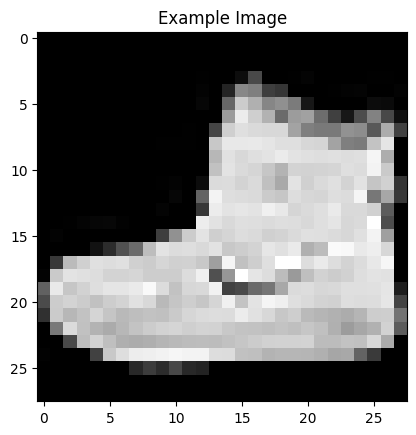

Min pixel value: 0, Max pixel value: 255

 numerical labels
Labels represent clothing categories: {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [10]:
# Example of a single image
sample_image = features[0].reshape(28, 28)
plt.imshow(sample_image, cmap='gray')
plt.title("Example Image")
plt.show()

print(f"Min pixel value: {features.min()}, Max pixel value: {features.max()}")

print("\n numerical labels")
label_map = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress",
    4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
}
print("Labels represent clothing categories:", label_map)

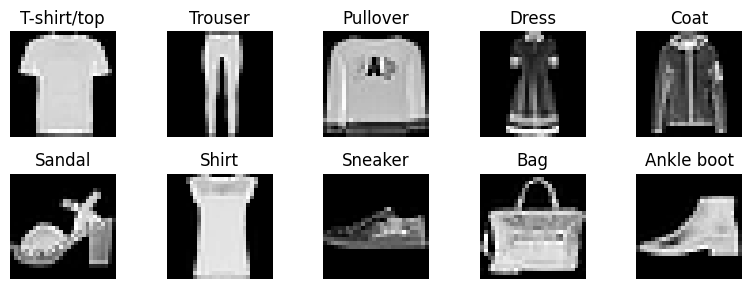

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_images(features, labels, label_map, seed=42):
    np.random.seed(seed)  
    plt.figure(figsize=(8, 3))
    unique_labels = np.unique(labels)
    for i, label in enumerate(unique_labels):
        indices = np.where(labels == label)[0]
        random_index = np.random.choice(indices)
        image = features[random_index].reshape(28, 28)
        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(label_map[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
plot_random_images(features, labels, label_map, seed=42)

C:\Users\MEHR\AppData\Local\Temp\ipykernel_11748\718076160.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


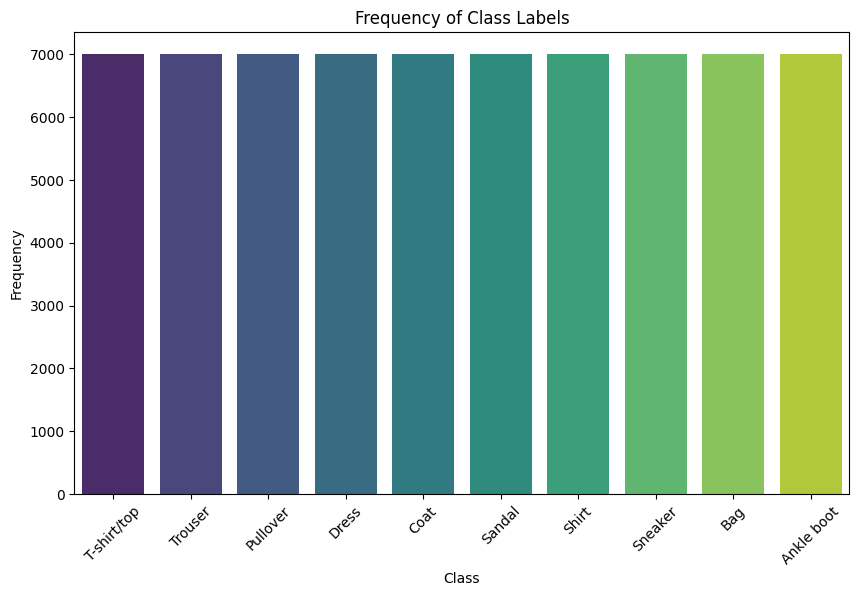

In [12]:
label_counts = pd.Series(labels).value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Frequency of Class Labels")
plt.xticks(ticks=np.arange(10), labels=[label_map[i] for i in range(10)], rotation=45)
plt.show()

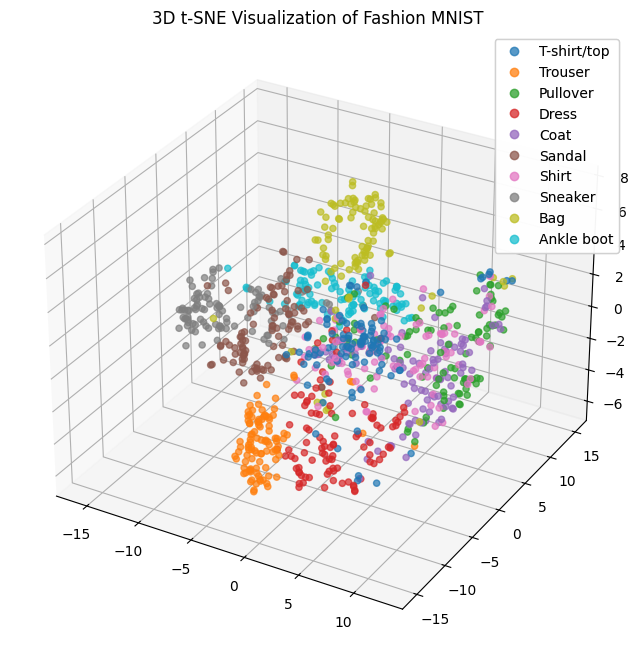

In [13]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Randomly sample 100 points per class
sampled_indices = []
for i in range(10): 
    class_indices = np.where(labels == i)[0]
    sampled_indices.extend(np.random.choice(class_indices, 100, replace=False))

sampled_features = features[sampled_indices]
sampled_labels = labels[sampled_indices]

tsne = TSNE(n_components=3, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(sampled_features)

# 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], 
                     c=sampled_labels, cmap='tab10', alpha=0.7)
legend = ax.legend(handles=scatter.legend_elements()[0],
                   labels=[label_map[i] for i in range(10)], loc="best")
ax.add_artist(legend)
plt.title("3D t-SNE Visualization of Fashion MNIST")
plt.show()

2 Data Preparation

2 part 1 Data Splitting

In [14]:
from sklearn.model_selection import train_test_split

train_features, temp_features, train_labels, temp_labels = train_test_split(
    features, labels, test_size=0.30, random_state=42, stratify=labels)

val_features, test_features, val_labels, test_labels = train_test_split(
    temp_features, temp_labels, test_size=0.50, random_state=42, stratify=temp_labels)

print("Training set shape:", train_features.shape, train_labels.shape)
print("Validation set shape:", val_features.shape, val_labels.shape)
print("Test set shape:", test_features.shape, test_labels.shape)

Training set shape: (49000, 784) (49000,)
Validation set shape: (10500, 784) (10500,)
Test set shape: (10500, 784) (10500,)


2 part 2 Preprocessing Function

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(train_features, val_features, test_features, variance_ratio=0.90):
    
    # a: Normalize using Min-Max
    scaler = MinMaxScaler()
    train_features_normalized = scaler.fit_transform(train_features)
    val_features_normalized = scaler.transform(val_features)
    test_features_normalized = scaler.transform(test_features)
    
    # b: PCA for dimensionality reduction
    pca = PCA(variance_ratio) 
    preprocessed_train = pca.fit_transform(train_features_normalized)
    preprocessed_val = pca.transform(val_features_normalized)
    preprocessed_test = pca.transform(test_features_normalized)
    
    print(f"Number of components retained: {pca.n_components_}")
    
    return preprocessed_train, preprocessed_val, preprocessed_test, pca

Number of components retained: 84
Preprocessed training set shape: (49000, 84)
Preprocessed validation set shape: (10500, 84)
Preprocessed testing set shape: (10500, 84)


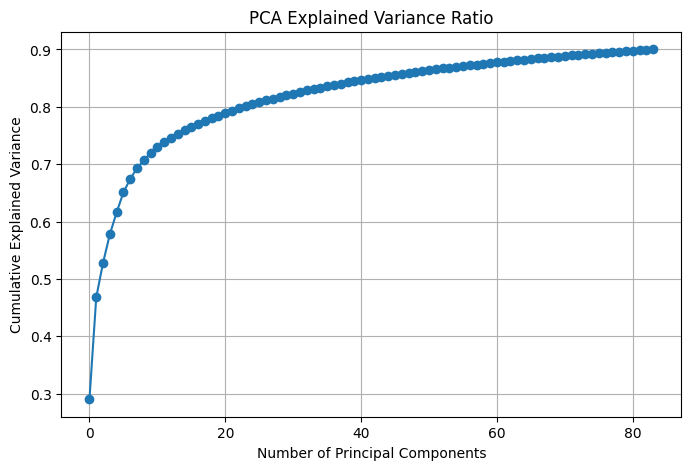

In [16]:
# Preprocess data with 90% variance retained
preprocessed_train, preprocessed_val, preprocessed_test, pca = preprocess_data(
    train_features, val_features, test_features, variance_ratio=0.90)

print("Preprocessed training set shape:", preprocessed_train.shape)
print("Preprocessed validation set shape:", preprocessed_val.shape)
print("Preprocessed testing set shape:", preprocessed_test.shape)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Ratio")
plt.grid()
plt.show()

3 Implementing the Classifier

In [17]:
def knn_predict(train_features, train_labels, eval_features, k,metric='euclidean', voting='weighted'):
    
    predictions = []
    train_features = train_features.astype(np.float32)
    train_labels = train_labels.astype(int)
    train_norms = np.sum(train_features**2, axis=1)
    
    for eval_feature in eval_features:
        eval_feature = eval_feature.astype(np.float32)
        #Compute squared distances
        eval_norm = np.sum(eval_feature**2)
        squared_dist = train_norms + eval_norm - 2 * np.dot(train_features, eval_feature.T)
        squared_dist = np.maximum(squared_dist, 0)
        distances = np.sqrt(squared_dist)
        
        #find indices of the k nearest neighbors
        k_indices = np.argpartition(distances, k)[:k]
        k_distances = distances[k_indices]
        k_labels = train_labels[k_indices]
        
        #sort k nearest neighbors
        sorted_indices = np.argsort(k_distances)
        k_indices = k_indices[sorted_indices]
        k_distances = k_distances[sorted_indices]
        k_labels = k_labels[sorted_indices]
        
        #distance weighted voting
        weights = 1 / (k_distances + 1e-6)  
        unique_labels, inverse = np.unique(k_labels, return_inverse=True)
        label_weights = np.bincount(inverse, weights=weights)
        predicted_label = unique_labels[np.argmax(label_weights)]
        predictions.append(predicted_label)
    
    return np.array(predictions)

In [18]:
# smaller subset testing KNN implementation
train_subset = preprocessed_train[:500]
train_labels_subset = train_labels[:500]
val_subset = preprocessed_val[:100]
val_labels_subset = val_labels[:100]

k = 5  
predicted_labels = knn_predict(train_subset, train_labels_subset, val_subset, k)
accuracy = np.mean(predicted_labels == val_labels_subset)
print(f"Validation Accuracy (k={k}): {accuracy:.2%}")

Validation Accuracy (k=5): 76.00%


4  Hyperparameter Tuning

4 part a Number of KNN neighbors

Evaluating for k=1...
Validation Accuracy for k=1: 84.90%
Evaluating for k=3...
Validation Accuracy for k=3: 86.05%
Evaluating for k=5...
Validation Accuracy for k=5: 86.67%
Evaluating for k=7...
Validation Accuracy for k=7: 86.81%
Evaluating for k=9...
Validation Accuracy for k=9: 86.67%


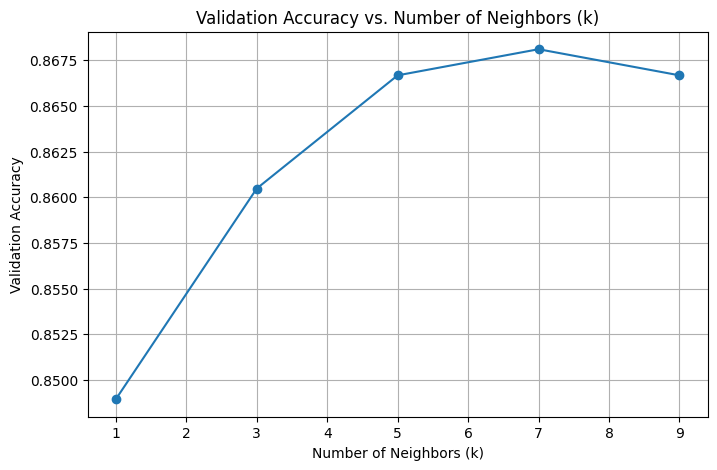

In [19]:
def evaluate_knn_with_different_k(train_features, train_labels, val_features, val_labels, k_values):

    results = {}
    for k in k_values:
        print(f"Evaluating for k={k}...")
        predictions = knn_predict(train_features, train_labels, val_features, k)
        accuracy = np.mean(predictions == val_labels)
        results[k] = accuracy
        print(f"Validation Accuracy for k={k}: {accuracy:.2%}")
    return results

#range of k values
k_values = [1, 3, 5, 7, 9]

# evaluate KNN for different k 
k_results = evaluate_knn_with_different_k(
    preprocessed_train, train_labels, preprocessed_val, val_labels, k_values
)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(k_values, list(k_results.values()), marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs. Number of Neighbors (k)")
plt.grid()
plt.show()

4 part b:  Variance threshold in PCA


Evaluating for PCA variance ratio=0.8...
Number of components retained: 24
Validation Accuracy for PCA variance ratio=0.8: 85.24%
Evaluating for PCA variance ratio=0.85...
Number of components retained: 43
Validation Accuracy for PCA variance ratio=0.85: 85.89%
Evaluating for PCA variance ratio=0.9...
Number of components retained: 84
Validation Accuracy for PCA variance ratio=0.9: 86.67%
Evaluating for PCA variance ratio=0.95...
Number of components retained: 188
Validation Accuracy for PCA variance ratio=0.95: 87.05%
Evaluating for PCA variance ratio=0.99...
Number of components retained: 460
Validation Accuracy for PCA variance ratio=0.99: 86.13%


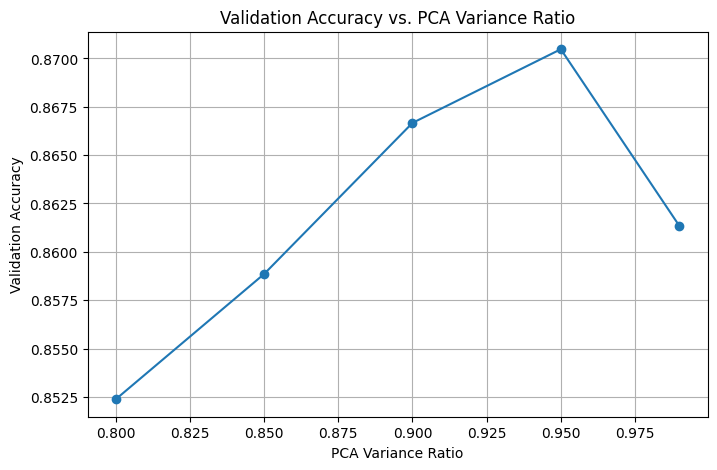

In [20]:
def evaluate_knn_with_pca_variance(train_features, val_features, test_features, 
                                   train_labels, val_labels, variance_ratios, k):
    results = {}
    train_features = train_features.astype(np.float32)
    val_features = val_features.astype(np.float32)
    test_features = test_features.astype(np.float32)
    train_labels = train_labels.astype(int)
    val_labels = val_labels.astype(int)
    
    for variance_ratio in variance_ratios:
        print(f"Evaluating for PCA variance ratio={variance_ratio}...")
    
        preprocessed_train, preprocessed_val, preprocessed_test, _ = preprocess_data(
            train_features, val_features, test_features, variance_ratio )
        
        predictions = knn_predict(preprocessed_train, train_labels, preprocessed_val, k)
        accuracy = np.mean(predictions == val_labels)
        results[variance_ratio] = accuracy
        print(f"Validation Accuracy for PCA variance ratio={variance_ratio}: {accuracy:.2%}")
    return results

#range of PCA variance ratios for test
variance_ratios = [0.80, 0.85, 0.90, 0.95, 0.99]

# evaluate KNN with PCA variance ratios
pca_results = evaluate_knn_with_pca_variance(
    train_features, val_features, test_features, train_labels, val_labels, variance_ratios, k=5)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(variance_ratios, list(pca_results.values()), marker='o')
plt.xlabel("PCA Variance Ratio")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs. PCA Variance Ratio")
plt.grid()
plt.show()

In [21]:
#the best hyperparameters
optimal_k = max(k_results, key=k_results.get)
optimal_pca_variance = max(pca_results, key=pca_results.get)

print(f"Optimal k: {optimal_k}")
print(f"Optimal PCA Variance Ratio: {optimal_pca_variance}")

Optimal k: 7
Optimal PCA Variance Ratio: 0.95


In [22]:
# Preprocess the data with the optimal PCA variance ratio
final_preprocessed_train, final_preprocessed_val, final_preprocessed_test, final_pca = preprocess_data(
    train_features, val_features, test_features, variance_ratio=optimal_pca_variance)
    
print(f"Number of PCA components retained: {final_pca.n_components_}")

# Validate the model with the optimal k
final_predictions = knn_predict(final_preprocessed_train, train_labels, final_preprocessed_val, optimal_k)
final_accuracy = np.mean(final_predictions == val_labels)

print(f"Validation Accuracy with optimal hyperparameters (k={optimal_k}, PCA variance ratio={optimal_pca_variance}): {final_accuracy:.2%}")

Number of components retained: 188
Number of PCA components retained: 188
Validation Accuracy with optimal hyperparameters (k=7, PCA variance ratio=0.95): 86.99%


4 part 3  (Bonus) Additional Hyperparameter Tuning

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
from tabulate import tabulate

def bonus_hyperparameter_tuning(train_features, val_features, test_features, train_labels, val_labels, variance_ratios, k_values):
    
    train_features = np.array(train_features, dtype=np.float32)
    val_features = np.array(val_features, dtype=np.float32)
    test_features = np.array(test_features, dtype=np.float32)
    train_labels = np.array(train_labels, dtype=np.int32)
    val_labels = np.array(val_labels, dtype=np.int32)

    results = []
    normalization_methods = ['min-max', 'z-score']
    distance_metrics = ['euclidean', 'manhattan']
    voting_mechanisms = ['distance']
    dimension_reduction_methods = ['PCA', 'LDA']

    for norm_method in normalization_methods:
        if norm_method == 'min-max':
            scaler = MinMaxScaler()
            train_scaled = scaler.fit_transform(train_features)
            val_scaled = scaler.transform(val_features)
            test_scaled = scaler.transform(test_features)
        elif norm_method == 'z-score':
            mean = np.mean(train_features, axis=0)
            std = np.std(train_features, axis=0) + 1e-8
            train_scaled = (train_features - mean) / std
            val_scaled = (val_features - mean) / std
            test_scaled = (test_features - mean) / std

        for dim_method in dimension_reduction_methods:
            if dim_method == 'PCA':
                for pca_var in variance_ratios:
                    pca = PCA(n_components=pca_var)
                    preprocessed_train = pca.fit_transform(train_scaled)
                    preprocessed_val = pca.transform(val_scaled)

                    for k in k_values:
                        for metric in distance_metrics:
                            for voting in voting_mechanisms:
                                knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=voting)
                                knn.fit(preprocessed_train, train_labels)
                                accuracy = knn.score(preprocessed_val, val_labels)
                                results.append({
                                    'Normalization': norm_method,
                                    'Dimension Reduction': dim_method,
                                    'Variance': pca_var,
                                    'K': k,
                                    'Distance Metric': metric,
                                    'Voting Mechanism': voting,
                                    'Validation Accuracy': accuracy,
                                    'Dimensions': pca.n_components_
                                })
                                print(f"Normalization: {norm_method}, {dim_method}: {pca_var}, K: {k}, "
                                      f"Metric: {metric}, Voting: {voting}, Accuracy: {accuracy:.2%}")

            elif dim_method == 'LDA':
                lda = LDA(n_components=min(len(np.unique(train_labels)) - 1, train_features.shape[1]))
                preprocessed_train = lda.fit_transform(train_scaled, train_labels)
                preprocessed_val = lda.transform(val_scaled)

                for k in k_values:
                    for metric in distance_metrics:
                        for voting in voting_mechanisms:
                            knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=voting)
                            knn.fit(preprocessed_train, train_labels)
                            accuracy = knn.score(preprocessed_val, val_labels)

                            results.append({
                                'Normalization': norm_method,
                                'Dimension Reduction': dim_method,
                                'Variance': '-',
                                'K': k,
                                'Distance Metric': metric,
                                'Voting Mechanism': voting,
                                'Validation Accuracy': accuracy,
                                'Dimensions': lda.n_components
                            })

                            print(f"Normalization: {norm_method}, {dim_method}, K: {k}, "
                                  f"Metric: {metric}, Voting: {voting}, Accuracy: {accuracy:.2%}")

    best_config = max(results, key=lambda x: x['Validation Accuracy'])
    return best_config, results

variance_ratios = [0.80, 0.90 , 0.95]
k_values = [1, 3, 5 , 7,9]

optimal_config, all_results = bonus_hyperparameter_tuning(
    train_features, val_features, test_features, train_labels, val_labels, variance_ratios, k_values)

results_df = pd.DataFrame(all_results)

print("\nBest Configuration:")
print(optimal_config)

impact_analysis = {'Normalization': results_df.groupby('Normalization')['Validation Accuracy'].mean(),
    'Dimension Reduction': results_df.groupby('Dimension Reduction')['Validation Accuracy'].mean(),
    'K': results_df.groupby('K')['Validation Accuracy'].mean(),
    'Distance Metric': results_df.groupby('Distance Metric')['Validation Accuracy'].mean(),
    'Voting Mechanism': results_df.groupby('Voting Mechanism')['Validation Accuracy'].mean()}

print("\nImpact Analysis:")
for key, value in impact_analysis.items():
    print(f"{key} Impact:")
    print(value, '\n')

summary_table = results_df[['Normalization', 'Dimension Reduction', 'Variance', 'K', 'Distance Metric', 'Validation Accuracy']]
summary_table = summary_table.sort_values(by='Validation Accuracy', ascending=False)
summary_table = summary_table.reset_index(drop=True)
summary_table['Validation Accuracy'] = summary_table['Validation Accuracy'].astype(np.float32)

output_file = "hyperparameter_tuning.xlsx"
summary_table.to_excel(output_file, index=False)

data = summary_table.values.tolist()
headers = summary_table.columns.tolist()
table = tabulate(data, headers=headers, tablefmt="grid", floatfmt=".5f")

print("\nSummary Table of Configurations and Their Accuracy:")
print(table)
print(f"\nThe results have been saved to {output_file}.")



Normalization: min-max, PCA: 0.8, K: 1, Metric: euclidean, Voting: distance, Accuracy: 83.14%
Normalization: min-max, PCA: 0.8, K: 1, Metric: manhattan, Voting: distance, Accuracy: 83.50%
Normalization: min-max, PCA: 0.8, K: 3, Metric: euclidean, Voting: distance, Accuracy: 84.74%
Normalization: min-max, PCA: 0.8, K: 3, Metric: manhattan, Voting: distance, Accuracy: 84.95%
Normalization: min-max, PCA: 0.8, K: 5, Metric: euclidean, Voting: distance, Accuracy: 85.24%
Normalization: min-max, PCA: 0.8, K: 5, Metric: manhattan, Voting: distance, Accuracy: 85.61%
Normalization: min-max, PCA: 0.8, K: 7, Metric: euclidean, Voting: distance, Accuracy: 85.37%
Normalization: min-max, PCA: 0.8, K: 7, Metric: manhattan, Voting: distance, Accuracy: 85.84%
Normalization: min-max, PCA: 0.8, K: 9, Metric: euclidean, Voting: distance, Accuracy: 85.43%
Normalization: min-max, PCA: 0.8, K: 9, Metric: manhattan, Voting: distance, Accuracy: 85.75%
Normalization: min-max, PCA: 0.9, K: 1, Metric: euclidean, V

5 Final Evaluation

In [24]:
# Preprocess data use optimal PCA variance ratio
final_preprocessed_train, final_preprocessed_val, final_preprocessed_test, _ = preprocess_data(
    train_features, val_features, test_features, variance_ratio=optimal_pca_variance)

test_predictions = knn_predict(final_preprocessed_train, train_labels, final_preprocessed_test, optimal_k)

# Calculate test accuracy
test_accuracy = np.mean(test_predictions == test_labels)
print(f"Test Accuracy with optimal hyperparameters (k={optimal_k}, PCA variance ratio={optimal_pca_variance}): {test_accuracy:.2%}")

Number of components retained: 188
Test Accuracy with optimal hyperparameters (k=7, PCA variance ratio=0.95): 86.16%


5_1 Per Class Metrics

In [25]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average=None)

test_labels_binarized = label_binarize(test_labels, classes=np.arange(10))
test_predictions_binarized = label_binarize(test_predictions, classes=np.arange(10))

auc_scores = [
    roc_auc_score(test_labels_binarized[:, i], test_predictions_binarized[:, i]) 
    for i in range(10)]

for i, label_name in enumerate(label_map.values()):
    print(f"Class: {label_name}")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1 Score: {f1[i]:.2f}")
    print(f"  AUC: {auc_scores[i]:.2f}\n")

Class: T-shirt/top
  Precision: 0.79
  Recall: 0.84
  F1 Score: 0.82
  AUC: 0.91

Class: Trouser
  Precision: 0.99
  Recall: 0.96
  F1 Score: 0.98
  AUC: 0.98

Class: Pullover
  Precision: 0.76
  Recall: 0.78
  F1 Score: 0.77
  AUC: 0.87

Class: Dress
  Precision: 0.89
  Recall: 0.89
  F1 Score: 0.89
  AUC: 0.94

Class: Coat
  Precision: 0.76
  Recall: 0.78
  F1 Score: 0.77
  AUC: 0.88

Class: Sandal
  Precision: 0.99
  Recall: 0.87
  F1 Score: 0.93
  AUC: 0.94

Class: Shirt
  Precision: 0.64
  Recall: 0.59
  F1 Score: 0.62
  AUC: 0.78

Class: Sneaker
  Precision: 0.91
  Recall: 0.96
  F1 Score: 0.93
  AUC: 0.97

Class: Bag
  Precision: 0.97
  Recall: 0.97
  F1 Score: 0.97
  AUC: 0.98

Class: Ankle boot
  Precision: 0.91
  Recall: 0.97
  F1 Score: 0.94
  AUC: 0.98



5_2. ROC Curves

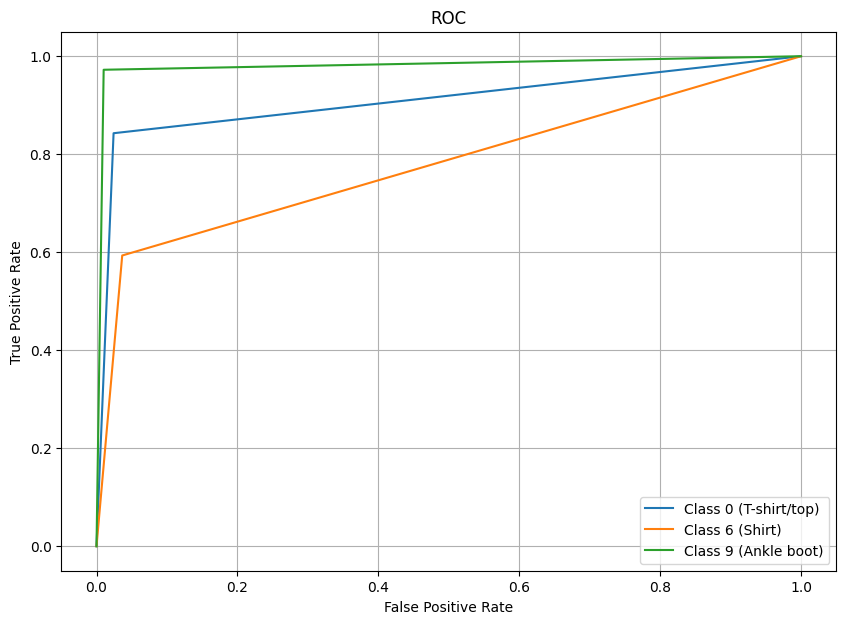

In [ ]:
classes_to_plot = [0, 6, 9]

plt.figure(figsize=(10, 7))
for class_id in classes_to_plot:
    fpr, tpr, _ = roc_curve(test_labels_binarized[:, class_id], test_predictions[:, class_id])
    plt.plot(fpr, tpr, label=f"Class {class_id} ({label_map[class_id]})")
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend()
plt.grid()
plt.show()

5_3. Overall Metrics

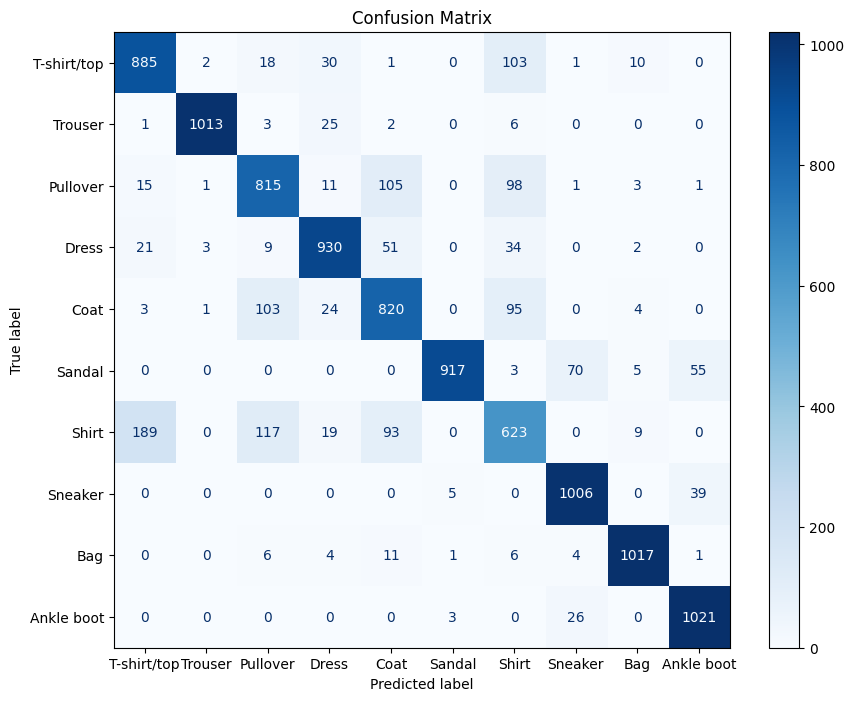

Overall Accuracy: 86.16%
Macro Precision: 0.86
Macro Recall: 0.86
Macro F1 Score: 0.86
Macro AUC: 0.92


In [28]:
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(conf_matrix, display_labels=label_map.values()).plot(cmap="Blues", ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)
macro_auc = np.mean(auc_scores)

print(f"Overall Accuracy: {test_accuracy:.2%}")
print(f"Macro Precision: {macro_precision:.2f}")
print(f"Macro Recall: {macro_recall:.2f}")
print(f"Macro F1 Score: {macro_f1:.2f}")
print(f"Macro AUC: {macro_auc:.2f}")